In this analysis I will be applying an AutoML model to predict total orders one step forward.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from sklearn.metrics import mean_squared_error
from pandas import concat
from pandas import DataFrame
import h2o
from h2o.automl import H2OAutoML
from scipy import stats
import datetime as dt

# Data engineering

### Importing the csv and setting index as timestamp

In [2]:
df = pd.read_csv("datasets/orders_autumn_2020.csv", parse_dates = ['TIMESTAMP'], index_col = "TIMESTAMP")
df

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
TIMESTAMP,,,,,,,,,,,,
2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:27:00,-1,1,60.170,24.946,60.170,24.945,24,23,0.0,12.8,2.34419,0.0
2020-09-30 19:36:00,-8,6,60.185,24.944,60.178,24.949,23,15,0.0,12.8,2.34419,0.0
2020-09-30 19:39:00,-14,3,60.186,24.949,60.188,24.956,25,11,0.0,12.8,2.34419,0.0


### Modifying the data frame by dropping unneeeded columns and adding usefull ones

In [3]:
#Adding driver support for .kml file which contains the area polygons
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
fp = "Datasets/PKS_pienalue.kml"
areas = gpd.read_file(fp, driver='KML')
#Creating new columns for both end-user location and restaurant locations
df["USER_POINT"] = df[["USER_LONG", "USER_LAT"]].apply(Point, axis=1)
df["VENUE_POINT"] = df[["VENUE_LONG", "VENUE_LAT"]].apply(Point, axis=1)
df['TOTAL_ORDERS'] = np.arange(1, (len(df)+1))
df.rename(columns={'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES': 'ACTUAL_VS_ESTIMATED'}, inplace = True)
df['DAY'] = df.index.weekday #Day column to describe weekdays from 0-6
df['DAILY_ORDERS'] = 1 #Column of daily orders that can be used after resampling
df.describe().transpose()
df_nan = df[df.isna().any(axis=1)]
df_nan

/Users/juuso/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,ACTUAL_VS_ESTIMATED,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,USER_POINT,VENUE_POINT,TOTAL_ORDERS,DAY,DAILY_ORDERS
TIMESTAMP,,,,,,,,,,,,,,,,,
2020-09-10 06:22:00,-1,2,60.175,24.922,60.179,24.922,21,20,NaN,NaN,NaN,0.0,POINT (24.922 60.175),POINT (24.922 60.17899999999999),11779,3,1
2020-09-10 06:29:00,4,1,60.159,24.944,60.162,24.939,22,26,NaN,NaN,NaN,0.0,POINT (24.944 60.159),POINT (24.939 60.162),11780,3,1
2020-09-10 06:31:00,1,2,60.162,24.926,60.168,24.938,25,26,NaN,NaN,NaN,0.0,POINT (24.926 60.162),POINT (24.938 60.168),11781,3,1
2020-09-10 06:38:00,-7,2,60.161,24.937,60.168,24.930,23,16,NaN,NaN,NaN,0.0,POINT (24.937 60.161),POINT (24.93 60.168),11782,3,1
2020-09-10 07:00:00,7,2,60.170,24.956,60.178,24.949,30,37,NaN,NaN,NaN,0.0,POINT (24.956 60.17),POINT (24.949 60.178),11783,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10 18:56:00,-10,4,60.172,24.956,60.178,24.949,34,24,NaN,NaN,NaN,0.0,POINT (24.956 60.172),POINT (24.949 60.178),12051,3,1
2020-09-10 19:07:00,4,1,60.178,24.929,60.168,24.930,23,27,NaN,NaN,NaN,0.0,POINT (24.929 60.178),POINT (24.93 60.168),12052,3,1
2020-09-10 19:09:00,11,6,60.156,24.932,60.168,24.930,23,34,NaN,NaN,NaN,0.0,POINT (24.932 60.15600000000001),POINT (24.93 60.168),12053,3,1


As we can see, one day is totally missing the weather data, so let's fill them out with daily avg data from Ilmatieteenlaitos

In [4]:
wdata = pd.read_csv('Datasets/weather09102020.csv')
#Data's cloud_coverage is displayed in decimal unlike in df
wdata['Pilvien määrä (1/8)'] = wdata['Pilvien määrä (1/8)'].apply(lambda x: x*10)

In [5]:
missing_clouds = wdata['Pilvien määrä (1/8)'].mean()
missing_temp = wdata['Ilman lämpötila (degC)'].mean()
missing_wind = wdata ['Tuulen nopeus (m/s)'].mean()
df['TEMPERATURE'].fillna(missing_temp, inplace=True)
df['CLOUD_COVERAGE'].fillna(missing_clouds, inplace=True)
df['WIND_SPEED'].fillna(missing_wind, inplace=True)
df_nan = df[df.isna().any(axis=1)]
df_nan

,ACTUAL_VS_ESTIMATED,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,USER_POINT,VENUE_POINT,TOTAL_ORDERS,DAY,DAILY_ORDERS
TIMESTAMP,,,,,,,,,,,,,,,,,


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ACTUAL_VS_ESTIMATED,18706.0,-1.201058,8.979834,-41.000000,-7.00000,-2.00000,5.00000,34.00000
ITEM_COUNT,18706.0,2.688228,1.886455,1.000000,1.00000,2.00000,4.00000,11.00000
USER_LAT,18706.0,60.175234,0.012674,60.153000,60.16300,60.17500,60.18600,60.20100
USER_LONG,18706.0,24.941244,0.016540,24.909000,24.92600,24.94300,24.95400,24.98000
VENUE_LAT,18706.0,60.175643,0.011509,60.149000,60.16700,60.17000,60.18600,60.21900
VENUE_LONG,18706.0,24.941214,0.014482,24.878000,24.93000,24.94100,24.95000,25.04200
ESTIMATED_DELIVERY_MINUTES,18706.0,33.809313,7.340283,10.000000,28.00000,33.00000,38.00000,82.00000
ACTUAL_DELIVERY_MINUTES,18706.0,32.608254,10.018879,6.000000,25.00000,32.00000,40.00000,58.00000
CLOUD_COVERAGE,18706.0,12.269368,23.739925,0.000000,0.00000,0.00000,25.00000,100.00000
TEMPERATURE,18706.0,16.913393,3.421892,6.100000,14.40000,16.70000,18.90000,26.70000


#### .describe() shows us that the dataset doesn't contain any significant outliers that need to be removed

### Mapping area names to coordinates and dropping the separate coordinate columns

In [7]:
df["AREA"] = ""
for i in range(len(df)):
    point = df["USER_POINT"].iloc[i]
    for j in range(len(areas)):
        poly = areas["geometry"].iloc[j]
        if poly.contains(point):
            df["AREA"].iloc[i] = areas["Name"].iloc[j]
df.drop(['USER_LAT', 'USER_LONG'], axis = 1, inplace = True)

/Users/juuso/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
df["VENUE_LOC"] = ""
for i in range(len(df)):
    point = df["VENUE_POINT"].iloc[i]
    for j in range(len(areas)):
        poly = areas["geometry"].iloc[j]
        if poly.contains(point):
            df["VENUE_LOC"].iloc[i] = areas["Name"].iloc[j]
df.drop(['VENUE_LAT', 'VENUE_LONG'], axis = 1, inplace = True)
df

,ACTUAL_VS_ESTIMATED,ITEM_COUNT,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,USER_POINT,VENUE_POINT,TOTAL_ORDERS,DAY,DAILY_ORDERS,AREA,VENUE_LOC
TIMESTAMP,,,,,,,,,,,,,,,
2020-08-01 06:07:00,-19,1,29,10,0.0,15.0,3.53644,0.0,POINT (24.946 60.158),POINT (24.946 60.16),1,5,1,Ullanlinna,Ullanlinna
2020-08-01 06:17:00,-7,8,39,32,0.0,15.0,3.53644,0.0,POINT (24.927 60.163),POINT (24.91 60.153),2,5,1,Kamppi,Jätkäsaari
2020-08-01 06:54:00,-17,4,23,6,0.0,15.0,3.53644,0.0,POINT (24.937 60.161),POINT (24.939 60.162),3,5,1,Punavuori,Punavuori
2020-08-01 07:09:00,-2,3,28,26,0.0,16.7,3.52267,0.0,POINT (24.954 60.185),POINT (24.911 60.19),4,5,1,Torkkelinmäki,Meilahti
2020-08-01 07:10:00,-1,2,27,26,0.0,16.7,3.52267,0.0,POINT (24.955 60.182),POINT (24.949 60.178),5,5,1,Linjat,Siltasaari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:27:00,-1,1,24,23,0.0,12.8,2.34419,0.0,POINT (24.946 60.17),POINT (24.945 60.17),18702,2,1,Kluuvi,Kluuvi
2020-09-30 19:36:00,-8,6,23,15,0.0,12.8,2.34419,0.0,POINT (24.944 60.185),POINT (24.949 60.178),18703,2,1,Linjat,Siltasaari
2020-09-30 19:39:00,-14,3,25,11,0.0,12.8,2.34419,0.0,POINT (24.949 60.18600000000001),POINT (24.956 60.188),18704,2,1,Linjat,Harju


## Comparing delivery time forecasts for each area

(20.0, 45.0)

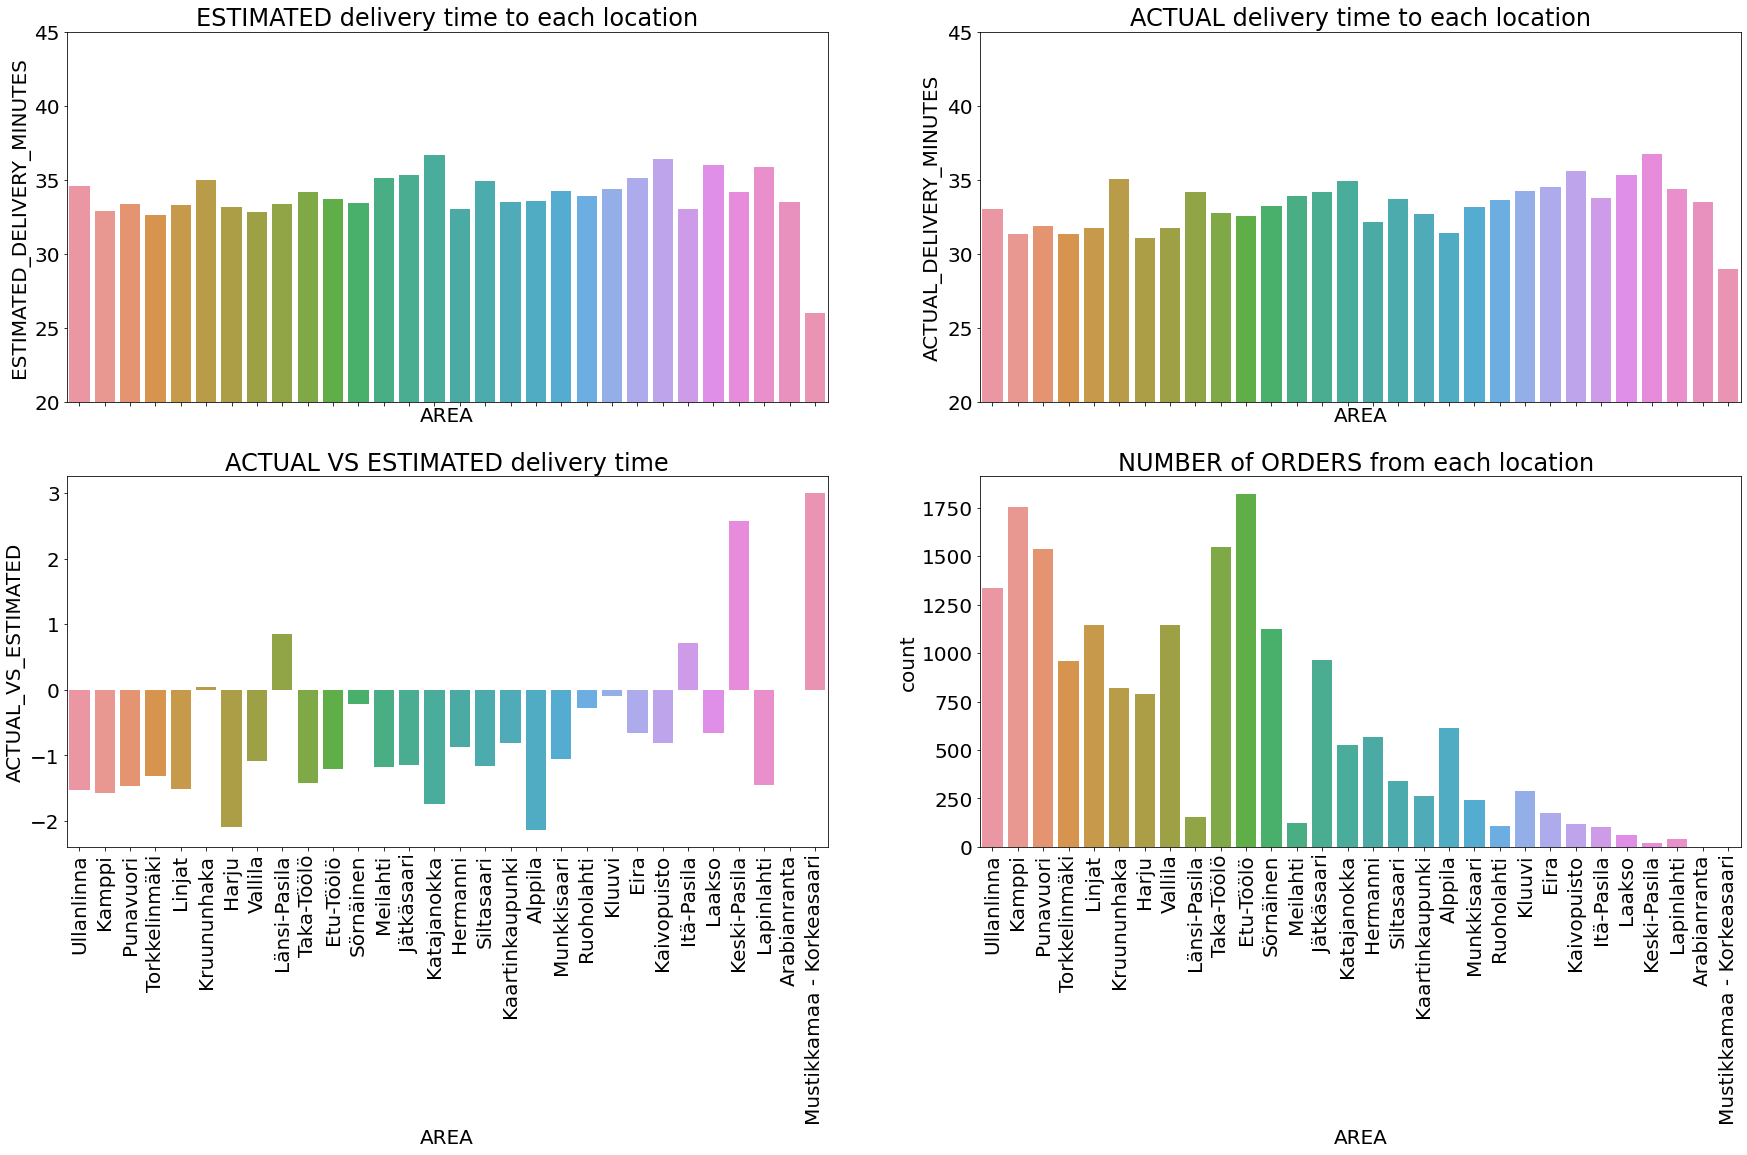

In [76]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(2, 2, figsize=(30, 15), sharex=True)
sns.barplot(ax=axes[0,0], data = df, x='AREA', y='ESTIMATED_DELIVERY_MINUTES', ci=None)
sns.barplot(ax=axes[0,1], data = df, x='AREA', y='ACTUAL_DELIVERY_MINUTES', ci=None)
sns.barplot(ax=axes[1,0], data = df, x='AREA', y='ACTUAL_VS_ESTIMATED', ci=None)
sns.countplot(ax=axes[1,1],data = df, x='AREA')
axes[0,0].set_title('ESTIMATED delivery time to each location')
axes[0,1].set_title('ACTUAL delivery time to each location')
axes[1,0].set_title('ACTUAL VS ESTIMATED delivery time')
axes[1,1].set_title('NUMBER of ORDERS from each location ')
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,1].tick_params(axis='x', rotation=90)
axes[0,0].set_ylim(20,45)
axes[0,1].set_ylim(20,45)

In [77]:
options = ['Itä-Pasila', 'Keski-Pasila', 'Länsi-Pasila']
df_pasila = df[df['AREA'].isin(options)] 
df_pasila.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ACTUAL_VS_ESTIMATED,278.0,0.913669,8.407047,-21.000000,-4.000000,0.00000,5.000000,26.00000
ITEM_COUNT,278.0,2.830935,1.962697,1.000000,1.000000,2.00000,4.000000,10.00000
ESTIMATED_DELIVERY_MINUTES,278.0,33.298561,7.529537,21.000000,28.000000,32.00000,37.000000,64.00000
ACTUAL_DELIVERY_MINUTES,278.0,34.212230,9.379384,11.000000,27.000000,34.00000,40.750000,56.00000
CLOUD_COVERAGE,278.0,11.951079,22.890313,0.000000,0.000000,0.00000,25.000000,75.00000
TEMPERATURE,278.0,17.043065,3.528382,6.100000,14.550000,16.70000,18.300000,26.10000
WIND_SPEED,278.0,3.810859,1.521596,0.839148,2.668718,3.55156,4.706292,9.85730
PRECIPITATION,278.0,0.281712,1.081642,0.000000,0.000000,0.00000,0.000000,6.31579
TOTAL_ORDERS,278.0,9800.798561,5452.065194,12.000000,5007.000000,9824.50000,14814.000000,18635.00000
DAY,278.0,3.338129,2.019951,0.000000,2.000000,4.00000,5.000000,6.00000


### Difference in total orders and delivery forecast for each day of the week

Text(0.5, 1.0, 'ACTUAL VS ESTIMATED delivery time each day')

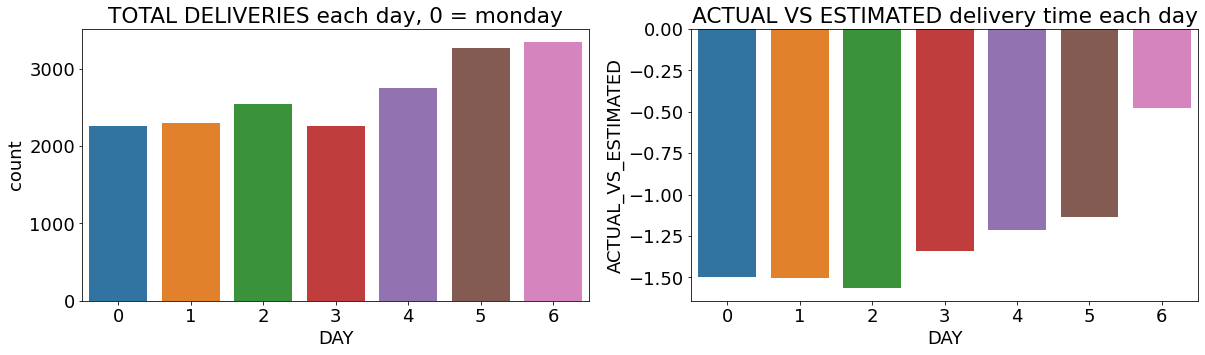

In [78]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(ax = axes[0], data = df, x = 'DAY')
sns.barplot(ax = axes[1], data = df, x = 'DAY', y = 'ACTUAL_VS_ESTIMATED', ci=None)
axes[0].set_title('TOTAL DELIVERIES each day, 0 = monday')
axes[1].set_title('ACTUAL VS ESTIMATED delivery time each day')

Text(0.5, 1.0, 'Total orders from each location')

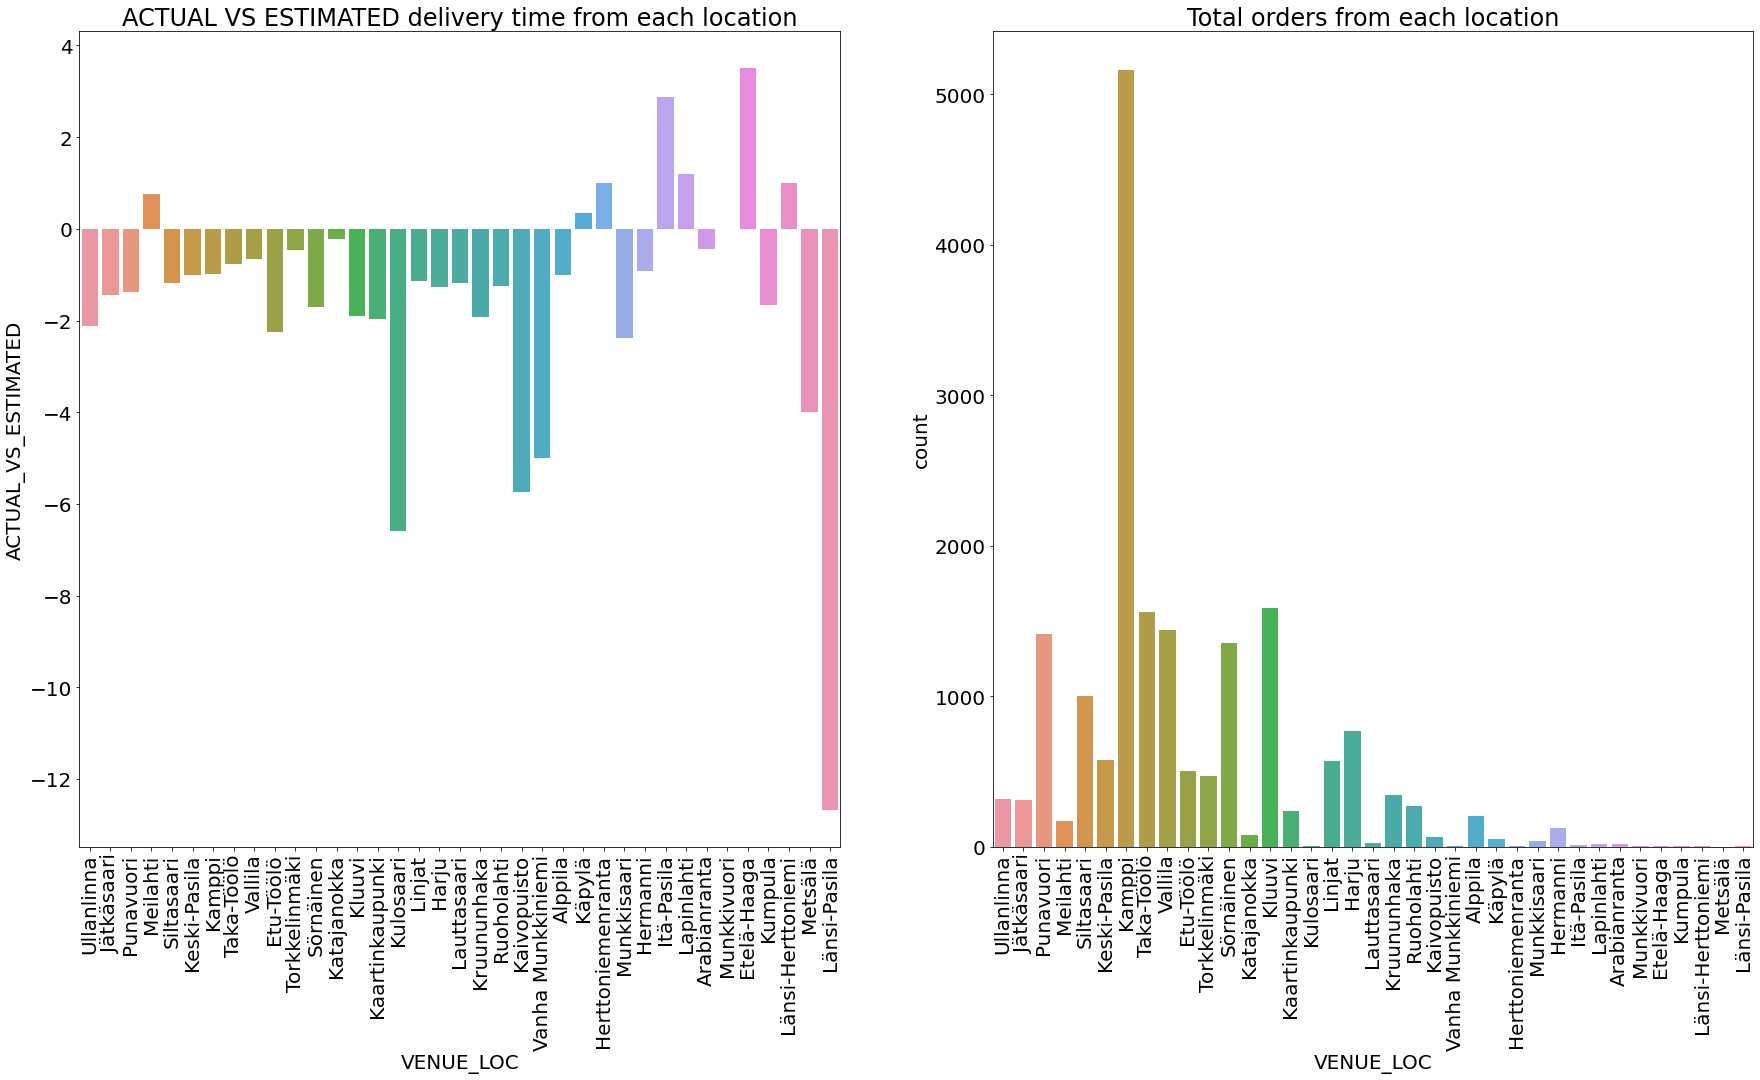

In [79]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
sns.barplot(ax=axes[0], data = df, x='VENUE_LOC', y='ACTUAL_VS_ESTIMATED', ci=None)
sns.countplot(ax=axes[1], data = df, x='VENUE_LOC')
axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=90)
axes[0].set_title('ACTUAL VS ESTIMATED delivery time from each location')
axes[1].set_title('Total orders from each location')

## Resampling the data to daily averages and coverting days to weekday/weekend binary values for the model

In [80]:
df_avg = df.resample('D').agg({'ACTUAL_VS_ESTIMATED': np.mean,
                               'ITEM_COUNT': np.mean,
                               'CLOUD_COVERAGE': np.mean,
                               'WIND_SPEED': np.mean,
                               'PRECIPITATION': np.mean,
                               'TEMPERATURE': np.mean,
                               'DAY': np.mean,
                               'DAILY_ORDERS': np.sum})
df_avg['WEEK_END']= ''
df_avg['DAY'].replace({0:1,
                       1:1,
                       2:1,
                       3:1,
                       4:0,
                       5:0,
                       6:0,}, inplace = True)
df_avg.rename(columns={"DAY": "WEEK_DAY"}, inplace = True)
df_avg['WEEK_END']= (df_avg['WEEK_DAY'])
df_avg['WEEK_END'].replace({0:1,
                           1:0,
                           2:0,
                           3:0,
                           4:1,
                           5:1,
                           6:1,}, inplace = True)
df_avg

,ACTUAL_VS_ESTIMATED,ITEM_COUNT,CLOUD_COVERAGE,WIND_SPEED,PRECIPITATION,TEMPERATURE,WEEK_DAY,DAILY_ORDERS,WEEK_END
TIMESTAMP,,,,,,,,,
2020-08-01,-0.515050,2.806020,5.769231,2.451263,0.000000,18.773244,0,299,1
2020-08-02,3.332317,3.033537,10.259146,4.777104,0.780809,19.196341,0,328,1
2020-08-03,0.163717,2.725664,15.707965,4.706736,0.729390,17.880531,1,226,0
2020-08-04,-0.793860,2.478070,14.692982,2.131851,0.735457,16.972368,1,228,0
2020-08-05,-1.832031,2.750000,11.406250,3.954401,0.000000,19.648437,1,256,0
...,...,...,...,...,...,...,...,...,...
2020-09-26,-2.505495,2.840659,0.000000,3.616059,0.000000,16.175549,0,364,1
2020-09-27,-1.696891,3.010363,0.000000,4.321162,0.000000,17.855181,0,386,1
2020-09-28,-2.728873,2.690141,2.288732,3.837791,0.000000,14.988732,1,284,0


<AxesSubplot:>

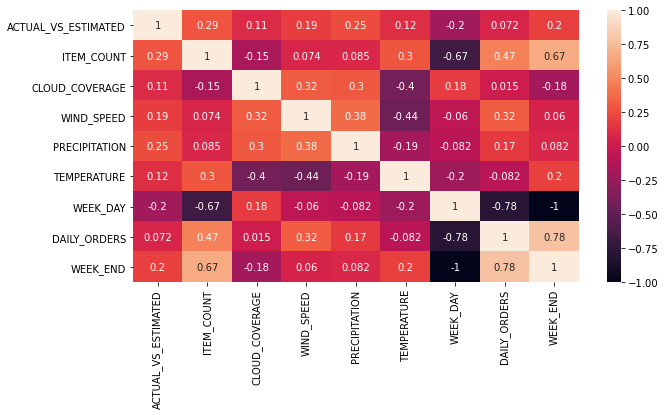

In [81]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize = (10,5))
corr = df_avg.corr()
sns.heatmap(corr, annot=True)


## Baseline Prediction model / Persistence model

Test MSE: 4001.923


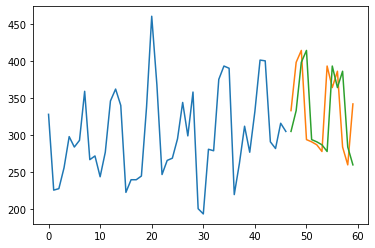

In [82]:
df1 = df_avg.copy()
#Copying the resampled frame and dropping unneeded columns/reseting the datetime index
df1.drop(['ACTUAL_VS_ESTIMATED','ITEM_COUNT','CLOUD_COVERAGE','WIND_SPEED','PRECIPITATION','WEEK_DAY','WEEK_END','TEMPERATURE'	],axis = 1, inplace=True)
df1.reset_index()
#Creating a lagged representation 
values = DataFrame(df1.values)
df_per = concat([values.shift(1), values], axis=1)
df_per.columns = ['t-1', 't+1']
df_per.head()

#Splitting the dataset into train (80%) and test (20%) sets
X = df_per.values
train_size = int(len(X) * 0.8)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x
 
# Go through Training set step by step and compare to Test data, count MSE value
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
 
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

The "Naive" forecast model gives us rather inaccurate prediction and is clearly one step behind reality. 

## Applying H2O AutoML model to predict orders
#### I chose to do AutoML because of it's model explainability and automatic search for the best model to use, after applying it we can evaluate its effectivenes with KPIs. 


#### Preprocessing: predicting daily orders one step ahead

In [106]:
df2 = df_avg.copy()
num_lags = 3 
delay = 1 # predict target one step ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('DAILY_ORDERS') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

In [107]:
mask = df_processed.columns.str.contains('DAILY_ORDERS')
df_processed[df_processed.columns[mask]].head(10)

,DAILY_ORDERS,DAILY_ORDERS_lag1,DAILY_ORDERS_avg_window_length2,DAILY_ORDERS_lag2,DAILY_ORDERS_avg_window_length3,DAILY_ORDERS_lag3,DAILY_ORDERS_avg_window_length4
TIMESTAMP,,,,,,,
2020-08-01,299,328.0,277.0,226.0,260.666667,228.0,259.50
2020-08-02,328,226.0,227.0,228.0,236.666667,256.0,252.00
2020-08-03,226,228.0,242.0,256.0,260.666667,298.0,266.50
2020-08-04,228,256.0,277.0,298.0,279.333333,284.0,282.75
2020-08-05,256,298.0,291.0,284.0,291.666667,293.0,308.50
2020-08-06,298,284.0,288.5,293.0,312.000000,359.0,300.75
2020-08-07,284,293.0,326.0,359.0,306.333333,267.0,297.75
2020-08-08,293,359.0,313.0,267.0,299.333333,272.0,285.50
2020-08-09,359,267.0,269.5,272.0,261.000000,244.0,265.00


In [108]:
df_processed.reset_index(drop=True,inplace=True)
#Choosing the size of the train data
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

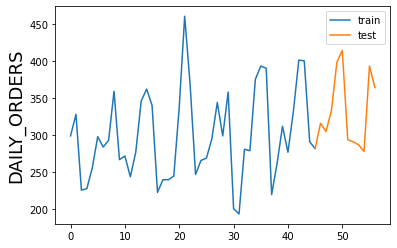

In [109]:
plt.plot(df_train.index,df_train['DAILY_ORDERS'])
plt.plot(df_test.index,df_test['DAILY_ORDERS'])
plt.ylabel('DAILY_ORDERS',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [110]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_281"; Java(TM) SE Runtime Environment (build 1.8.0_281-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from /Users/juuso/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/py/wrfllc_x5z5bnp2dcbrj_0900000gn/T/tmpe6m8a_r9
  JVM stdout: /var/folders/py/wrfllc_x5z5bnp2dcbrj_0900000gn/T/tmpe6m8a_r9/h2o_juuso_started_from_python.out
  JVM stderr: /var/folders/py/wrfllc_x5z5bnp2dcbrj_0900000gn/T/tmpe6m8a_r9/h2o_juuso_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Helsinki
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_juuso_t1um84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [111]:
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [112]:
hf_train.describe()

Rows:46
Cols:55




,DAILY_ORDERS,ACTUAL_VS_ESTIMATED_lag1,ACTUAL_VS_ESTIMATED_avg_window_length2,ACTUAL_VS_ESTIMATED_lag2,ACTUAL_VS_ESTIMATED_avg_window_length3,ACTUAL_VS_ESTIMATED_lag3,ACTUAL_VS_ESTIMATED_avg_window_length4,ITEM_COUNT_lag1,ITEM_COUNT_avg_window_length2,ITEM_COUNT_lag2,ITEM_COUNT_avg_window_length3,ITEM_COUNT_lag3,ITEM_COUNT_avg_window_length4,CLOUD_COVERAGE_lag1,CLOUD_COVERAGE_avg_window_length2,CLOUD_COVERAGE_lag2,CLOUD_COVERAGE_avg_window_length3,CLOUD_COVERAGE_lag3,CLOUD_COVERAGE_avg_window_length4,WIND_SPEED_lag1,WIND_SPEED_avg_window_length2,WIND_SPEED_lag2,WIND_SPEED_avg_window_length3,WIND_SPEED_lag3,WIND_SPEED_avg_window_length4,PRECIPITATION_lag1,PRECIPITATION_avg_window_length2,PRECIPITATION_lag2,PRECIPITATION_avg_window_length3,PRECIPITATION_lag3,PRECIPITATION_avg_window_length4,TEMPERATURE_lag1,TEMPERATURE_avg_window_length2,TEMPERATURE_lag2,TEMPERATURE_avg_window_length3,TEMPERATURE_lag3,TEMPERATURE_avg_window_length4,WEEK_DAY_lag1,WEEK_DAY_avg_window_length2,WEEK_DAY_lag2,WEEK_DAY_avg_window_length3,WEEK_DAY_lag3,WEEK_DAY_avg_window_length4,DAILY_ORDERS_lag1,DAILY_ORDERS_avg_window_length2,DAILY_ORDERS_lag2,DAILY_ORDERS_avg_window_length3,DAILY_ORDERS_lag3,DAILY_ORDERS_avg_window_length4,WEEK_END_lag1,WEEK_END_avg_window_length2,WEEK_END_lag2,WEEK_END_avg_window_length3,WEEK_END_lag3,WEEK_END_avg_window_length4
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real
mins,194.0,-3.338607594936709,-3.0971726499273724,-3.338607594936709,-2.9216386234751046,-3.338607594936709,-2.712585751525926,2.4082278481012658,2.428704087985059,2.4082278481012658,2.4737459877347203,2.4082278481012658,2.493625642003789,0.0,0.6250000000000051,0.0,1.126681614349778,0.0,1.6868479454562075,1.827402340425528,2.139000973125002,1.827402340425528,2.1602274473894587,1.827402340425528,2.228797828145643,0.0,0.0,0.0,0.0,0.0,0.0,12.91199999999993,12.213844158539109,9.095409836065626,12.218738948535602,9.095409836065626,12.519770291803734,0.0,0.0,0.0,0.0,0.0,0.25,194.0,197.5,194.0,225.33333333333337,194.0,237.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,299.15217391304344,-0.8149165588522955,-0.8821780238315216,-0.9494394888107468,-0.9244121888588708,-1.0088805189135694,-0.9525486598864343,2.6787252668599697,2.6723735684089163,2.666021869957861,2.6694588855832126,2.6636295199318063,2.670155357669587,12.87635126572804,13.037468883898168,13.198586502068284,13.007814174030484,12.948504754295117,12.935255130524101,3.70836713182157,3.7480452686874757,3.787723405553381,3.7567100016645556,3.774039467618717,3.776216113138871,0.4002300448525188,0.39768515096659474,0.3951402570806709,0.39155141822201156,0.3792839527328449,0.3844875018878587,17.714005236486553,17.60421250140666,17.494419766326782,17.526658383590743,17.371550147958892,17.468590541533636,0.5869565217391305,0.597826086956522,0.6086956521739131,0.5942028985507248,0.5869565217391305,0.5869565217391305,299.5217391304348,299.27173913043475,299.0217391304347,299.963768115942,301.34782608695656,301.233695652174,0.41304347826086957,0.40217391304347827,0.391304347826087,0.4057971014492752,0.41304347826086957,0.41304347826086957
maxs,460.0,3.332317073170732,1.748016943665012,1.2186379928315412,0.9794238602059332,1.2186379928315412,0.973670459257014,3.033536585365854,2.928806109725686,2.9551122194513715,2.848834945463324,2.9551122194513715,2.812830156772285,39.39873417721519,32.24035069516499,39.39873417721519,25.561784758922116,39.39873417721519,21.506565841918857,7.096000000000003,6.268853084476323,8.427492524590132,5.864600153707104,8.427492524590132,5.826536052780332,3.2882276059850435,1.6441138029925215,3.2882276059850435,1.1888904983926143,3.2882276059850435,1.3983509029342152,25.32354948805466,25.319852738456255,25.32354948805466,23.711237655849743,25.32354948805466,22.88008317146477,1.0,1.0,1.0,1.0,

In [113]:
y = 'DAILY_ORDERS'
X = hf_train.columns
X.remove(y)

In [114]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |███████████
16:25:38.547: Skipping training of model GBM_5_AutoML_20210128_162521 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20210128_162521.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 46.0.


█████████████████████████████████████████████| 100%


In [115]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid__1_AutoML_20210128_162521_model_37,745.182,27.298,745.182,22.4116,0.0855489
StackedEnsemble_BestOfFamily_AutoML_20210128_162521,753.631,27.4523,753.631,20.486,0.078926
StackedEnsemble_AllModels_AutoML_20210128_162521,889.72,29.8282,889.72,23.6504,0.0885152
XGBoost_grid__1_AutoML_20210128_162521_model_34,938.791,30.6397,938.791,23.3243,0.08857
GBM_grid__1_AutoML_20210128_162521_model_91,957.227,30.9391,957.227,24.207,0.08854
DeepLearning_grid__2_AutoML_20210128_162521_model_5,979.838,31.3024,979.838,27.3218,0.0940949
GBM_grid__1_AutoML_20210128_162521_model_93,1050.28,32.4081,1050.28,26.2401,0.0943349
XGBoost_grid__1_AutoML_20210128_162521_model_50,1074.29,32.7764,1074.29,28.7388,0.100619
GLM_1_AutoML_20210128_162521,1101.73,33.1923,1101.73,24.871,0.0936662
GBM_grid__1_AutoML_20210128_162521_model_99,1103.67,33.2215,1103.67,27.2882,0.0973345


After running it a few times, MAE is always between 18 and 22.5, which are acceptable numbers with the averages.

### Choosing the leader model

In [116]:
leader_model = aml.leader

In [117]:
hf_test_predict = leader_model.predict(hf_test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [118]:
hf_test_predict.head(5)

predict
282.005
302.897
265.048
358.713
396.215


In [119]:
df_results = pd.DataFrame()
df_results['REALITY'] = df_test['DAILY_ORDERS'].reset_index(drop=True)
df_results['PREDICTIONS'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.head()

,REALITY,PREDICTIONS
0,282,282.005280
1,316,302.897064
2,305,265.048126
3,333,358.713379
4,398,396.214600


The model gives us rather accurate forecast, but if productionized should be ran multiple times to see the actual accuracy

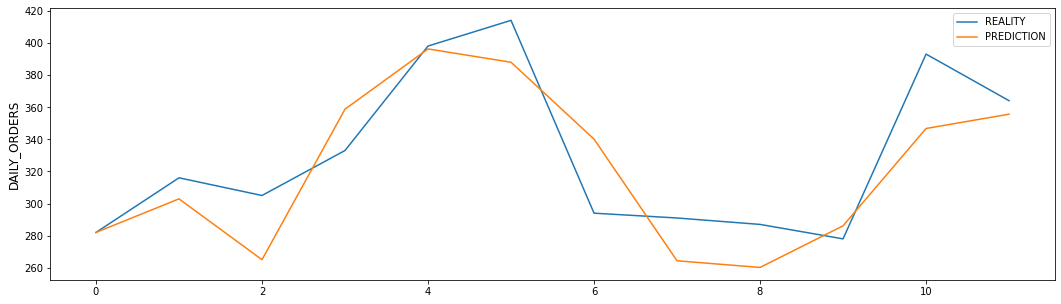

In [120]:
plt.figure(figsize=(18,5))
plt.plot(df_results['REALITY'])
plt.plot(df_results['PREDICTIONS'])
plt.ylabel('DAILY_ORDERS',fontsize=12)
plt.legend(['REALITY','PREDICTION'])
plt.show()

In [121]:
h2o.cluster().shutdown()

H2O session _sid_9c28 closed.


In [122]:
leader_model.varimp(use_pandas=True).head()

,variable,relative_importance,scaled_importance,percentage
0,WIND_SPEED_lag1,51258.656250,1.000000,0.168799
1,WEEK_DAY_lag3,37011.492188,0.722054,0.121882
2,DAILY_ORDERS_lag1,32596.011719,0.635912,0.107341
3,ITEM_COUNT_lag2,29006.185547,0.565879,0.095520
4,WEEK_DAY_avg_window_length4,22873.599609,0.446239,0.075324


In [125]:
22.4116/(df_avg['DAILY_ORDERS'].mean())

0.0730839089062333

In [126]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['PREDICTIONS'],y=df_results['REALITY'])
print('R2 = ',r_value*r_value)

R2 =  0.7281174588299381
